## PSF quantification script

*This version works as of October 2022*

Written by Nicholas Sofroniew, modified by Adam Glaser & Kevin Bishop

This script computes the average PSF size from a volume of diffraction limited beads for the purposes of characterizing microscope resolution.

Usage: A relatively small (~1mm^3 or less) data volume should be collected, ensuring SBR is moderately high (50 - 100x). The volume should be fused as a TIFF stack (16 bit, no downsampling, one channel per stack) sliced along the XY (highest resolution) plane. To achieve this, open the hdf5 dataset in BigStitcher, *Multiview > right-click > Interactively reorient sample...* Press *shift + Y* to orient the sample view in the XY (highest resolution) plane and click *Apply tranformation*. Define a bounding box (to fuse a subvolume if the dataset is large) and fuse to a compressed TIFF stack. Finally open the TIFF stack in FIJI (import as virtual stack for faster loading). Confirm that each single image shows the XY plane - the PSF should look circular and symmetric, not stretched. Click *Image > properties* and note the pixel sampling (width / height / depth; should all be the same) to input below.

Note: the script may take several hours to run (it will appear stuck on 'getting centers | Smoothing...')

**Coordinate convention**

*This is my current understanding, but the results don't fully make sense (Y res better than X res)*

    X: tile width (i.e. control code Y)

    Y: scan direction (i.e. control code X)

    Z: gravity direction (i.e. control code Z)

## Setup environment

In [35]:
import os
import numpy as np
import json
from skimage.io import imread
from skimage.io import imsave
from psf import compute
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas
import warnings
import time

## Define plotting functions

In [36]:
def plot_scatter(h_ax, v_ax, save_name, data_in, save_plot=True, plot_title=''):
    plt.subplots()
    plt.scatter(data_in[h_ax]*sampling,data_in[v_ax])
    plt.ylabel(v_ax + ' ($\mu$m)', fontsize = 12)
    plt.xlabel(h_ax + ' ($\mu$m)', fontsize = 12)
    plt.ylim(bottom=0)
    plt.title(plot_title, fontsize = 12)
    if save_plot:
        print('Saving plot')
        plt.savefig(os.path.join(data_base_path,save_name))

#    if h_ax != 'x_center':
#        warnings.warn("\n\n Warning - horizontal axis is mislabeled\n")

def plot_histo(h_ax, h_max_lim, save_name, data_in, anno='', save_plot=True):
    plt.subplots()
    bins = np.linspace(0,h_max_lim,31)
    plt.hist(data_in[h_ax], bins = bins, edgecolor = 'black')
    plt.xlabel(h_ax + ' ($\mu$m)', fontsize = 12)
    plt.ylabel(r'N', fontsize = 12)
    plt.title(r'Median = ' + str(round(np.median(data_in[h_ax]),3)) + r'um   Stand. Dev. = ' + 
              str(round(np.std(data_in[h_ax]),3)) + 'um', fontsize = 12)
    plt.annotate(anno, xy=(0.0*plt.xlim()[1], 0.9*plt.ylim()[1]))
    plt.savefig(os.path.join(data_base_path,save_name))

def plot_scatter_heat(h_ax, v_ax, color_ax, save_name, data_in, save_plot=True, plot_title='', clim=[]):

    plt.subplots()
    plt.scatter(data_in[h_ax]*sampling, data_in[v_ax]*sampling, marker='.', s=20, linewidths=0.5, 
                c=data_in[color_ax], cmap=plt.cm.seismic)
    cbar = plt.colorbar()
    cbar.set_label(color_ax + ' ($\mu$m)', fontsize = 12)
    
    plt.ylabel(v_ax + ' ($\mu$m)', fontsize = 12)
    plt.xlabel(h_ax + ' ($\mu$m)', fontsize = 12)
    
    if clim == []:
        med_val = np.median(data_in[color_ax])
        max_val = np.max(data_in[color_ax])
        min_val = np.min(data_in[color_ax])

        reach = np.max([max_val - med_val, med_val - min_val])
        plt.clim([med_val - reach, med_val + reach])
    else:
        plt.clim(clim)

    plt.title(plot_title, fontsize = 12)
    
    if save_plot:
        print('Saving plot')
        plt.savefig(os.path.join(data_base_path,save_name))



## Define parameters

In [37]:
sampling = 0.2454022 # um/px - see instructions above
wavelength = 638.0 # nm
NA = 0.4*1.33 # approximate collection NA
bead_size = 0.150 # um
windowUm = [8, 4, 4] # um - generally a few times the expected resolution. Too big may slow down script, too small may truncate PSFs.
options = {'pxPerUmLat':1.0/sampling, 'pxPerUmAx':1.0/sampling, 'wavelength':wavelength, 'NA':NA, 'bead_size':bead_size, 'windowUm':windowUm}
options['thresh'] = 0.1

# tif stack should be placed in its own directory
data_base_path = 'A:\\OTLS4_water-beads_256px_561-2176-9-2520_638-2172-9-2535_try2\\638'
tiff_name = 'fused_tp_0_ch_1_illum_0.tif'


**Example:**

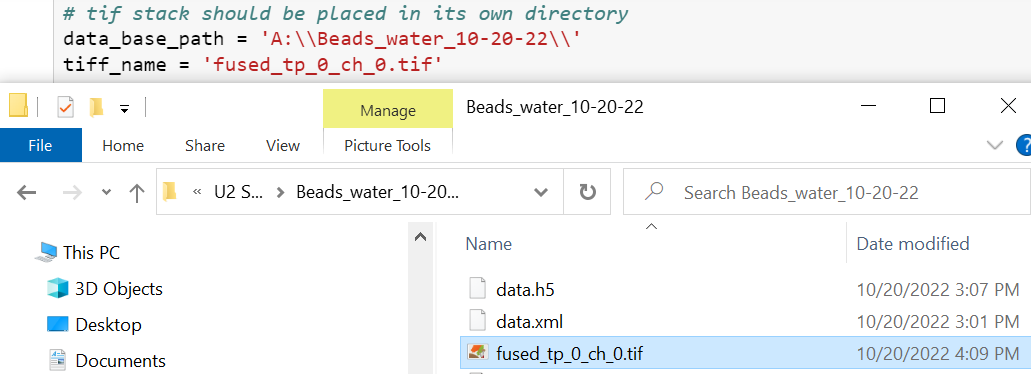

## Compute PSFs
Run this cell to generate new PSF data (may take several hours to run)

In [40]:
try: data
except NameError:
    print('Computing PSFs data')
    
    start = time.time()
    
    tiff_path = os.path.join(data_base_path,tiff_name)
    im = imread(tiff_path, plugin='tifffile')
    data, smoothed = compute(im, options)
    
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Execution time: {:0>2}hrs {:0>2}mins {:05.2f}secs".format(int(hours),int(minutes),seconds))
    
else: print('Error data is already defined! Delete \'data\' variable (\'del data\') and try again')


Computing PSFs data
getting centers
Smoothing...
Finding centers...
Found 4317 beads
Keeping 2259 beads
Finding maxima
got centers
Found bounds
Computing PSFs...
Found PSFs
Execution time: 01hrs 14mins 39.93secs


## Load PSF data
Run this cell to load saved PSF data (that has been previously generated by this script)

In [85]:
try: data
except NameError:
    print('Loading data')
    data = pandas.read_csv(os.path.join(data_base_path,'PSF_data.csv'), delimiter=',')
    print('Done')
else: print('Error data is already defined! Delete \'data\' variable (\'del data\') and try again')


Loading data
Done


## Plot PSF stats

<IPython.core.display.Javascript object>


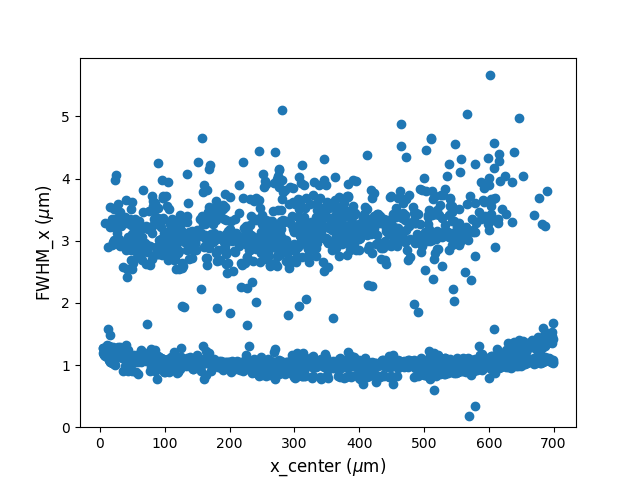

Saving plot


In [47]:
h_ax = 'x_center'
v_ax = 'FWHM_x'
save_name = 'x_depth_plot.svg'
plot_scatter(h_ax, v_ax, save_name, data, save_plot=True)

<IPython.core.display.Javascript object>


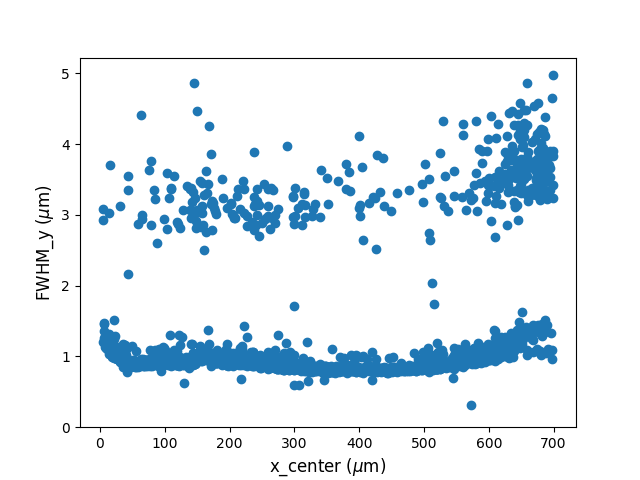

Saving plot


In [48]:
h_ax = 'x_center'
v_ax = 'FWHM_y'
save_name = 'y_depth_plot.svg'
plot_scatter(h_ax, v_ax, save_name, data, save_plot=True)

<IPython.core.display.Javascript object>


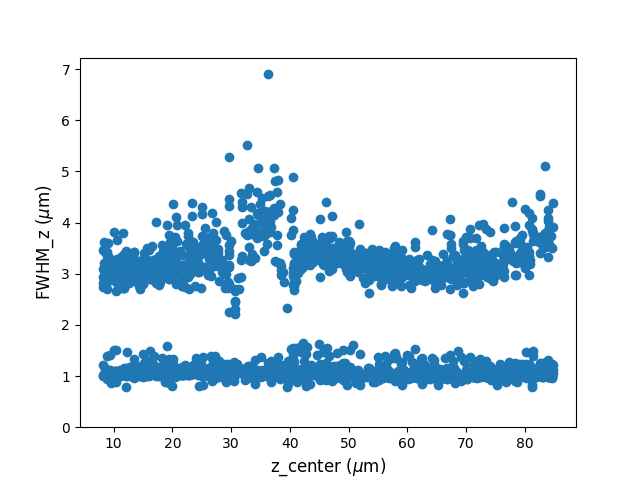

Saving plot


In [49]:
h_ax = 'z_center'
v_ax = 'FWHM_z'
save_name = 'z_depth_plot.svg'
plot_scatter(h_ax, v_ax, save_name, data, save_plot=True)

<IPython.core.display.Javascript object>


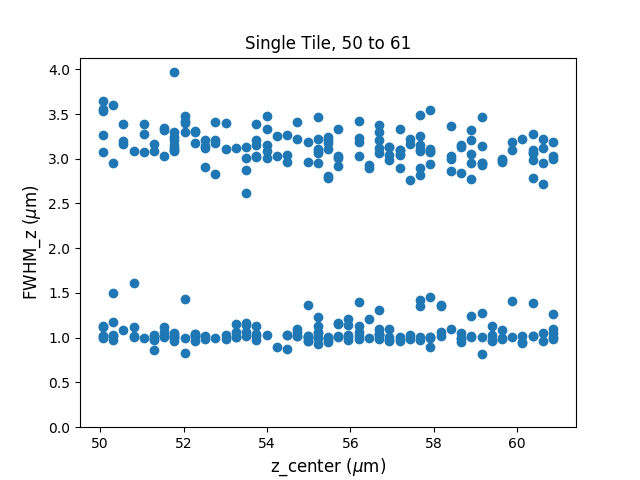

Saving plot


In [50]:
# plot only one tile
# NOTE: tile boundaries must be manually adjusted based on plot above

tile_min = 50
tile_max = 61

data['z_center']
data_one_tile = data[(data['z_center']*sampling > tile_min) & (data['z_center']*sampling < tile_max)] 

h_ax = 'z_center'
v_ax = 'FWHM_z'
save_name = 'z_depth_plot_single_tile.svg'
title_string = 'Single Tile, ' + str(tile_min) + ' to ' + str(tile_max)
plot_scatter(h_ax, v_ax, save_name, data_one_tile, save_plot=True, plot_title=title_string)


<IPython.core.display.Javascript object>


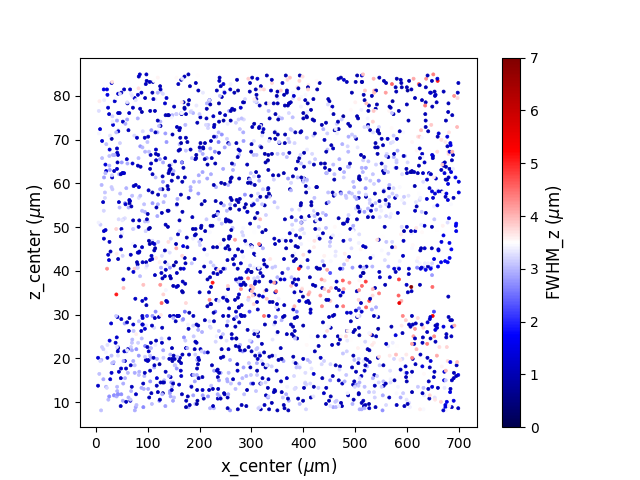

Saving plot


In [51]:
h_ax = 'x_center'
v_ax = 'z_center'
color_ax = 'FWHM_z'
save_name = 'xy_heat_plot.svg'
plot_scatter_heat(h_ax, v_ax, color_ax, save_name, data, save_plot=True, clim=[0,7])

<IPython.core.display.Javascript object>


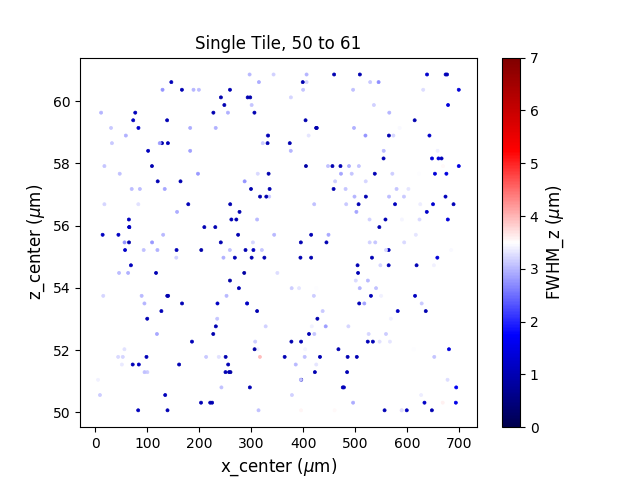

Saving plot


In [52]:
h_ax = 'x_center'
v_ax = 'z_center'
color_ax = 'FWHM_z'
save_name = 'xy_heat_plot_single_tile.svg'
title_string = 'Single Tile, ' + str(tile_min) + ' to ' + str(tile_max)
plot_scatter_heat(h_ax, v_ax, color_ax, save_name, data_one_tile, plot_title=title_string, save_plot=True, clim=[0,7])

<IPython.core.display.Javascript object>


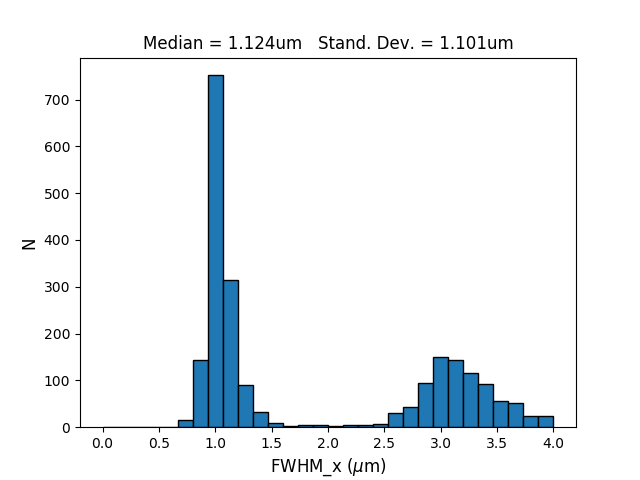

In [55]:
h_ax = 'FWHM_x'
h_max_lim = 4.0
save_name = 'x_histo.svg'

plot_histo(h_ax, h_max_lim, save_name, data, save_plot=True)

<IPython.core.display.Javascript object>


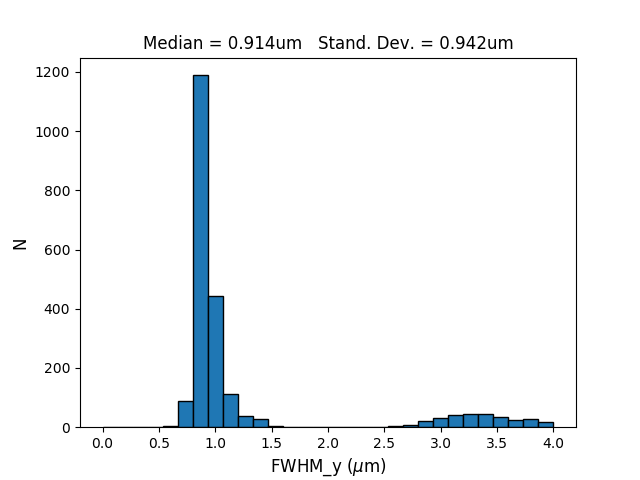

In [56]:
h_ax = 'FWHM_y'
h_max_lim = 4.0
save_name = 'y_histo.svg'

plot_histo(h_ax, h_max_lim, save_name, data, save_plot=True)


<IPython.core.display.Javascript object>


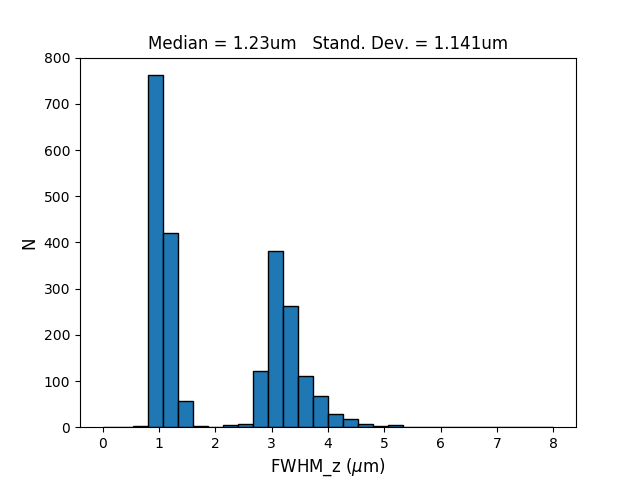

In [57]:
h_ax = 'FWHM_z'
h_max_lim = 8.0
save_name = 'z_histo.svg'

plot_histo(h_ax, h_max_lim, save_name, data, save_plot=True)

<IPython.core.display.Javascript object>


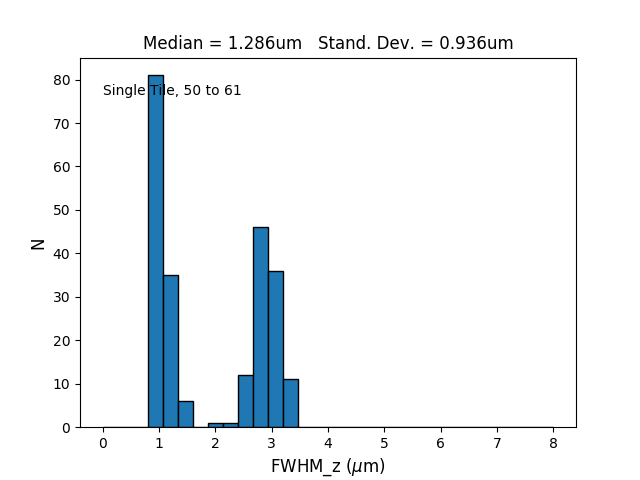

In [21]:
# plot single tile only (defined above)

h_ax = 'FWHM_z'
h_max_lim = 8.0
save_name = 'z_histo_single_tile.svg'
anno_string = 'Single Tile, ' + str(tile_min) + ' to ' + str(tile_max)

plot_histo(h_ax, h_max_lim, save_name, data_one_tile, anno=anno_string, save_plot=True)
#def plot_histo(h_ax, h_max_lim, save_name, data_in, anno='', save_plot=True):


***
***
## Plot average PSFs (slices)

*The rest of the script cannot be run with loaded (previously computed) data as the complete PSFs are not stored. To run the below sections, the PSFs must be recomputed from the raw data (above)*

(66, 32, 32)


<IPython.core.display.Javascript object>


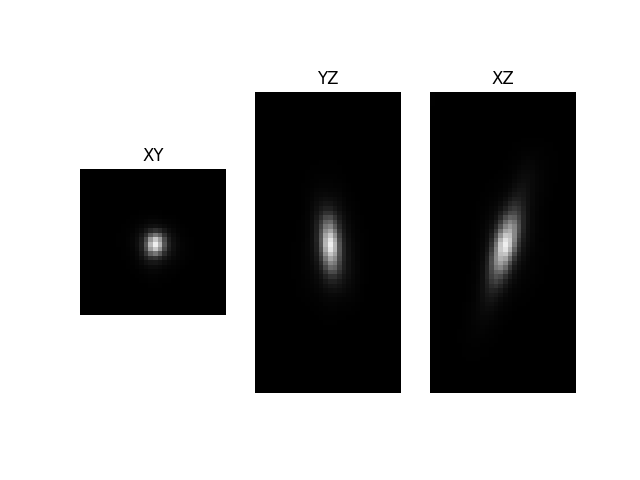

In [58]:
average_psf = np.zeros(data['bead'][0].shape)
for i in range (data['bead'].shape[0]):
    average_psf = average_psf + data['bead'][i]

average_psf = average_psf/data['bead'].shape
print(average_psf.shape)
fig, axs = plt.subplots(1,3)

XY = average_psf[int(average_psf.shape[0]/2),:,:]
YZ = average_psf[:,int(average_psf.shape[1]/2),:]
XZ = average_psf[:,:,int(average_psf.shape[2]/2)]

axs[0].imshow(XY, vmin = 0, vmax = 1, cmap='gray');
axs[0].axis('off');
axs[0].set_title('XY')

axs[1].imshow(YZ, vmin = 0, vmax = 1, cmap='gray');
axs[1].axis('off');
axs[1].set_title('YZ')

axs[2].imshow(XZ, vmin = 0, vmax = 1, cmap='gray');
axs[2].axis('off');
axs[2].set_title('XZ')



In [59]:
save_path = os.path.join(data_base_path, 'XZ.tif')
if not os.path.exists(save_path):
    imsave(save_path,(XZ*255).astype('uint8'))
else:
    raise Exception('File already exists')
    
save_path = os.path.join(data_base_path, 'YZ.tif')
if not os.path.exists(save_path):
    imsave(save_path,(YZ*255).astype('uint8'))
else:
    raise Exception('File already exists')
    
save_path = os.path.join(data_base_path, 'XY.tif')
if not os.path.exists(save_path):
    imsave(save_path,(XY*255).astype('uint8'))
else:
    raise Exception('File already exists')

## Save raw data

In [60]:
save_path = os.path.join(data_base_path, 'PSF_data.csv')
if not os.path.exists(save_path):
    data.to_csv(os.path.join(data_base_path, 'PSF_data.csv'))
else:
    raise Exception('File already exists')

## Plot max projection of bead locations

<IPython.core.display.Javascript object>


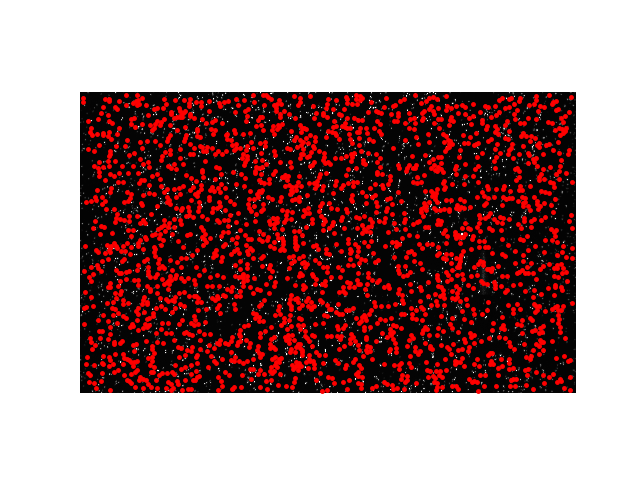

In [61]:
plt.subplots()
plt.imshow(smoothed, vmin = 0, vmax = 10000, cmap='gray');
plt.plot(data['x_center'], data['y_center'], 'r.', ms=5);

# uncomment below to zoom in on plot
# plt.xlim([0, 0+smoothed.shape[0]/4])
# plt.ylim([smoothed.shape[1]/4, 500])
plt.axis('off');

## Plot average PSFs (projections)

<IPython.core.display.Javascript object>


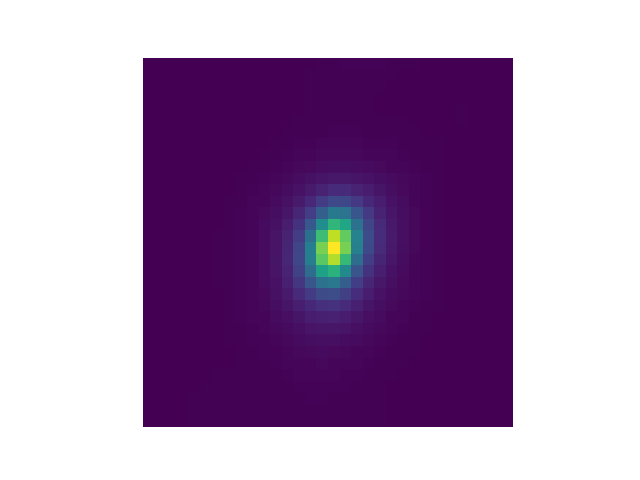

In [62]:
plt.subplots()
plt.imshow(average_psf.mean(axis=0));
plt.axis('off');

<IPython.core.display.Javascript object>


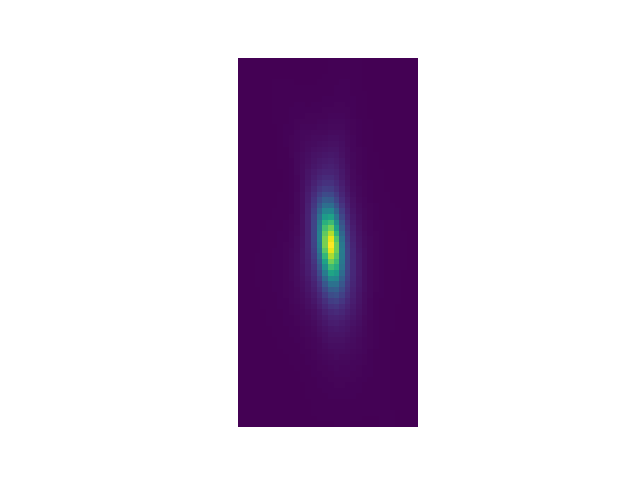

In [63]:
plt.subplots()
plt.imshow(average_psf.mean(axis=1), aspect = options['pxPerUmLat']/options['pxPerUmAx']);
plt.axis('off');

<IPython.core.display.Javascript object>


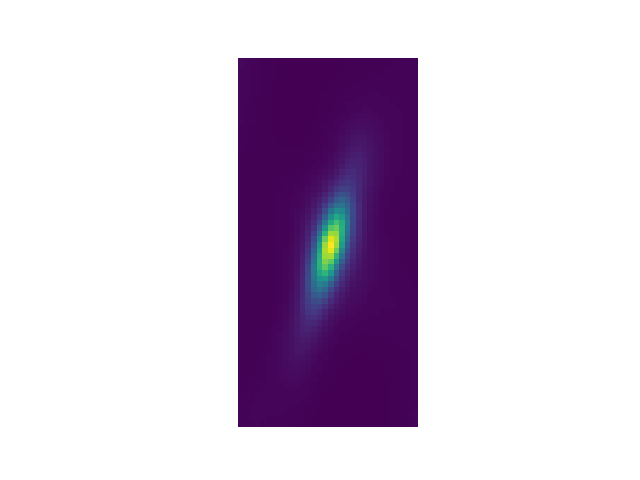

In [64]:
plt.subplots()
plt.imshow(average_psf.mean(axis=2), aspect = options['pxPerUmLat']/options['pxPerUmAx']);
plt.axis('off');

Works until here, plotting section belowdoes not work currently

## Plotting

In [ ]:
plotPSF(latProfile[beadInd][0],latProfile[beadInd][1],latProfile[beadInd][2],latProfile[beadInd][3],pxPerUmLat,PSF.Max.iloc[beadInd])

In [ ]:
plotPSF(axProfile[beadInd][0],axProfile[beadInd][1],axProfile[beadInd][2],axProfile[beadInd][3],pxPerUmAx,PSF.Max.iloc[beadInd])